In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import healpy as hp
import easygems.healpix as egh
import cartopy.crs as ccrs
import numpy as np
%run ~/hackathon-2025_project/hk25-AusNode-land/analysis/yll_functions.ipynb

In [2]:
# define paths
datapath = '/g/data/qx55/germany_node/d3hp003.zarr'
file = 'PT1H'
zoom = 'z7'
file_era5 = '/g/data/rt52/era5/single-levels/reanalysis/2t/2020/2t_era5_oper_sfc_20200101-20200131.nc'
era5_template = xr.open_dataset(file_era5).isel(time=0)
lats=era5_template.latitude.values
lons=era5_template.longitude.values

# define the fname
fpath = f'{datapath}/{file}_point_{zoom}_atm.zarr'

# open the zarr file
ds = xr.open_zarr(fpath).sel(time=slice('2020-03','2021-02'))
#ds_jja = ds.sel(time=ds['time'].dt.month.isin([6, 7, 8]))

# what variables are there in the dataset?
for key, longname in ds.data_vars.items():
    print(f'{key}: {longname.long_name}')

'''
#### some variables of interest ####

hflsd: latent heat flux
hfssd: sensible heat flux
huss: specific humidity in 2m
mrso: Water content of soil layers
orog: surface altitude
pr: precipitation flux
rlds: surface downwelling longwave radiation
rldscs: surface downwelling clear-sky longwave radiation
rlus: surface upwelling longwave radiation
rsds: surface downwelling shortwave radiation
rsdscs: surface downwelling clear-sky shortwave radiation
rsus: surface upwelling shortwave radiation
sftlf: cell area fraction occupied by land including lakes
tas: temperature in 2m
tauu: u-momentum flux at the surface
tauv: v-momentum flux at the surface
ts: surface temperature
uas: zonal wind in 10m
vas: meridional wind in 10m
'''


/home/561/yl1269/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/561/yl1269/.local/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


orog: surface altitude
pr: precipitation flux
psl: mean sea level pressure
rlut: toa outgoing longwave radiation
rsut: toa outgoing shortwave radiation
sftgif: cell area fraction occupied by land ice
sftlf: cell area fraction occupied by land including lakes
ts: surface temperature
uas: zonal wind in 10m
vas: meridional wind in 10m


'\n#### some variables of interest ####\n\nhflsd: latent heat flux\nhfssd: sensible heat flux\nhuss: specific humidity in 2m\nmrso: Water content of soil layers\norog: surface altitude\npr: precipitation flux\nrlds: surface downwelling longwave radiation\nrldscs: surface downwelling clear-sky longwave radiation\nrlus: surface upwelling longwave radiation\nrsds: surface downwelling shortwave radiation\nrsdscs: surface downwelling clear-sky shortwave radiation\nrsus: surface upwelling shortwave radiation\nsftlf: cell area fraction occupied by land including lakes\ntas: temperature in 2m\ntauu: u-momentum flux at the surface\ntauv: v-momentum flux at the surface\nts: surface temperature\nuas: zonal wind in 10m\nvas: meridional wind in 10m\n'

In [3]:
land = ds['sftlf']
#pr = xr.where(land >0.9, ds['pr'], np.nan)
pr = ds['pr']

# nside for um simulation, it should be equal to 2**zoom
this_nside = hp.get_nside(land)

cells = get_nn_lon_lat_index(this_nside, lons, lats) 

cells

<xarray.DataArray (lat: 721, lon: 1440)>
array([[ 32767,  49151,  49151, ...,  32767,  32767,  32767],
       [ 32767,  49151,  49151, ...,  32767,  32767,  32767],
       [ 32765,  49150,  49150, ...,  32765,  32765,  32765],
       ...,
       [147457, 163842, 163842, ..., 147457, 147457, 147457],
       [147456, 163840, 163840, ..., 147456, 147456, 147456],
       [180224, 131072, 131072, ..., 180224, 180224, 180224]])
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

In [4]:
pr_hourly_clm = pr.groupby('time.hour').mean(dim='time')
pr_hourly_clm

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: merging cohorts
INFO:flox:Entering _validate_reindex: reindex is False
INFO:flox:Leaving _validate_reindex: reindex is False


<xarray.DataArray 'pr' (hour: 24, cell: 196608)>
dask.array<transpose, shape=(24, 196608), dtype=float32, chunksize=(4, 196608), chunktype=numpy.ndarray>
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: cell
Attributes:
    grid_mapping:        crs
    hiopy::time_method:  point
    hiopy::nnn:          4
    hiopy::enable:       True
    standard_name:       pr
    units:               kg m-2 s-1
    short_name:          
    long_name:           precipitation flux

In [5]:
max_pr_hour = pr_hourly_clm.argmax(dim='hour')
max_pr_hour

<xarray.DataArray 'pr' (cell: 196608)>
dask.array<nanarg_agg-aggregate, shape=(196608,), dtype=int64, chunksize=(196608,), chunktype=numpy.ndarray>
Dimensions without coordinates: cell

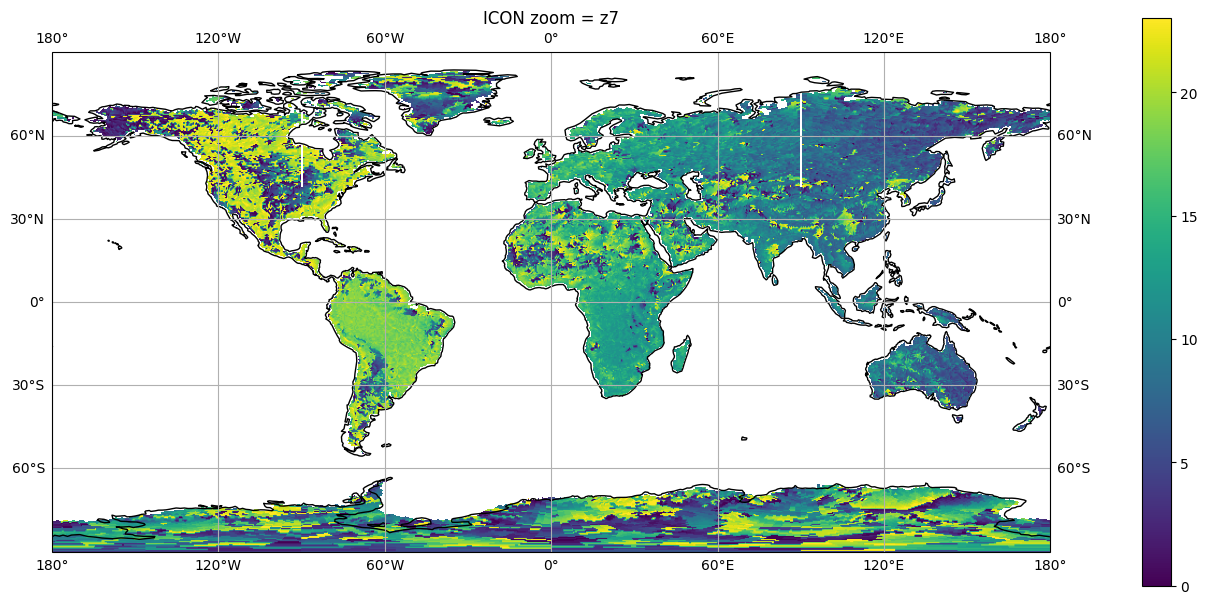

In [6]:
# test plot some data
plt.close('all')
projection=ccrs.PlateCarree(central_longitude=0.0)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection}, layout='constrained')

data = xr.where(land >0.9, max_pr_hour, np.nan)
ax.set_global()
im = egh.healpix_show(data.values,ax=ax)
ax.set_title(f'ICON zoom = {zoom}')
ax.coastlines()
ax.gridlines(draw_labels=True)
fig.colorbar(im,orientation='vertical')

plt.show()


In [7]:
# nside for um simulation, it should be equal to 2**zoom
this_nside = hp.get_nside(max_pr_hour)

cells = get_nn_lon_lat_index(this_nside, lons, lats) 

cells

max_pr_hour_regrided = max_pr_hour.isel(cell = cells) # regriding
max_pr_hour_regrided = max_pr_hour_regrided.rename({'lon': 'longitude', 'lat': 'latitude'}) # we need to change the names to match ERA5 data
land_regrided = land.isel(cell = cells)
land_regrided = land_regrided.rename({'lon': 'longitude', 'lat': 'latitude'}) # we need to change the names to match ERA5 data

max_pr_hour_regrided

<xarray.DataArray 'pr' (latitude: 721, longitude: 1440)>
dask.array<reshape, shape=(721, 1440), dtype=int64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

In [8]:
local_time_adj = 24*max_pr_hour_regrided.longitude/360
local_time_adj

<xarray.DataArray 'longitude' (longitude: 1440)>
array([-12.      , -11.983334, -11.966666, ...,  11.95    ,  11.966666,
        11.983334], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8

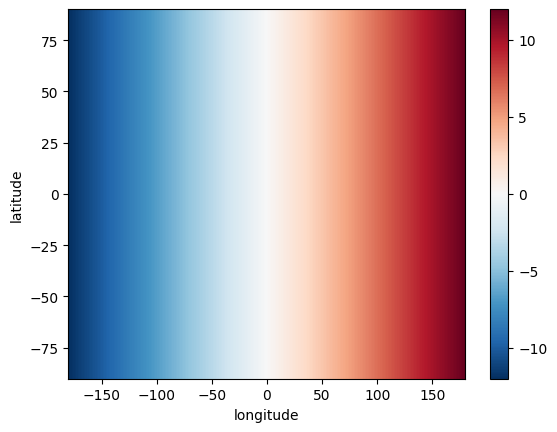

In [9]:
# Expand to (lat, lon) using broadcasting
local_time_adj_regrid = np.tile(local_time_adj, (len(max_pr_hour_regrided.latitude), 1))  # shape: (lat, lon)

# Optional: wrap into xarray
local_time_adj_regrid_da = xr.DataArray(
    local_time_adj_regrid,
    coords={'latitude': max_pr_hour_regrided.latitude, 'longitude': max_pr_hour_regrided.longitude},
    dims=('latitude', 'longitude')
)
local_time_adj_regrid_da.plot()

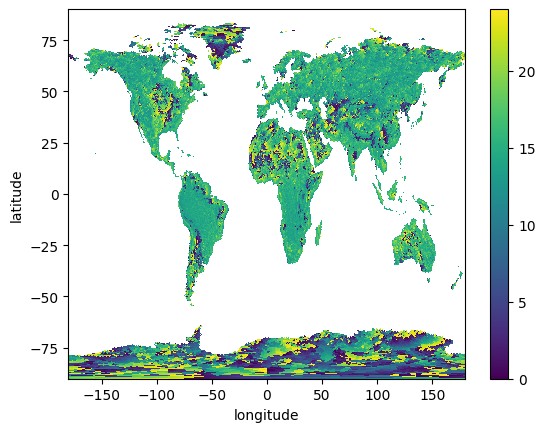

In [10]:
max_pr_hour_regrided_LT = (max_pr_hour_regrided + 24 + local_time_adj_regrid_da)%24
max_pr_hour_regrided_LT=xr.where(land_regrided >0.9, max_pr_hour_regrided_LT, np.nan)
max_pr_hour_regrided_LT.plot()

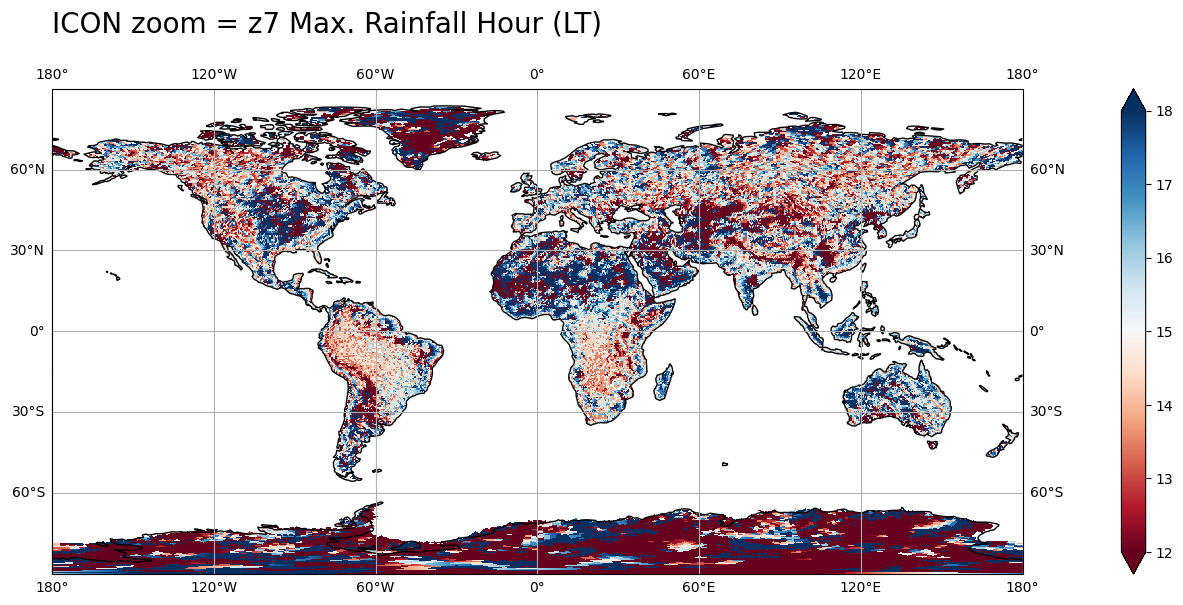

In [12]:
plt.close('all')
projection=ccrs.PlateCarree(central_longitude=0.0)
fig, ax = plt.subplots(figsize=(13, 6), subplot_kw={'projection': projection}, layout='constrained')

ax.set_global()
im = max_pr_hour_regrided_LT.plot(ax=ax,cmap='RdBu',vmin=12, vmax=18)
ax.set_title(f'ICON zoom = {zoom} Max. Rainfall Hour (LT)', loc='left', fontsize=20, y=1.1)
ax.coastlines()
ax.gridlines(draw_labels=True)
#fig.colorbar(im,orientation='vertical')

plt.show()
